# Indianapolis Office Involved Shootings
## Geocoding and Mapping in Python

Open data is becoming more and more popular in cities across the US. Many cities have portals which provide citizens access to data about various aspects of their community. Information about education, transportation, zoning, recreation, and crime is made available. By providing this information, the city is able promote honesty and transparency in the local government. Indianapolis, the capital city of Indiana, has an open data portal found [here](https://www.google.com).

For this post, I used the [IMPD Officer Involved Shooting dataset](http://data.indy.gov/datasets/4c173d2d845e453c878e13e39b86316f_15). This dataset contains information on Indianapolis Metropolitan Police Department (IMPD) officer involved shootings in Indianapolis and Marion County from January 2014 to March 2017.  

The goals of this post is to illustrate how to clean up a dataset and visualize the results. From this analysis, I hope to answer two questions: Where are the shootings occurring in Indianapolis, and are the number of officer involved shootings increasing?

In [1]:
import numpy as np #Used for data wrangling
import pandas as pd #Used for data wrangling
import seaborn as sns #Used for data vis
import matplotlib.pyplot as plt #Used for data vis
from geopy.geocoders import ArcGIS #Used for Geoencoding
import folium #Used for creating Leaflet.js maps
from folium import plugins #Used for more advanced mapping options
%matplotlib inline

## Step 1: Data Ingest and Wrangling

The data from Open Indy are available in a number of formats. For this analysis, because the dataset was small (only around 100 rows), I simply downloaded the data as a .csv file. The Pandas python package makes reading in a .csv file extremely easy:

In [2]:
data = pd.read_csv('/Users/jreinhart/Desktop/Data Analysis Github/Indianapolis /IMPD_Officer_Involved_Shootings.csv')

That's it, isn't Python amazing? Pandas takes care of all the heavy lifting and now we have a dataframe of our .csv file nicely sorted into rows and columns. Let's take a look at the first few rows of data.

In [3]:
data.head(5)

,﻿OBJECTID,INCNUM,SERVICE_TYPE,OCCURRED_DT,OCCURRED_TM,UDTEXT24A,UDTEXT24B,UDTEXT24C,UDTEXT24D,DISPOSITION,...,CIT_AGE,CIT_WEAPON,CIT_COND_TYPE,OFFNUM,OFF_WEAPON,OFF_RACE,OFF_SEX,OFF_AGE,OFF_YR_EMPLOY,OFF_COND_TYPE
0,1,19850,NaN,2017-03-05,03:08:00:000,OPERATIONS DIVISION,NORTHWEST DISTRICT,NW LATE SHIFT,NaN,NaN,...,23,Suspect - Handgun,Gunshot Wound,3118,IMPD - Duty Handgun,White,Male,30,8,NaN
1,2,19988,Call For Service,2016-10-19,15:10:00:000,OPERATIONS DIVISION,EAST DISTRICT,ED MIDDLE SHIFT,NaN,NaN,...,51,NaN,Gunshot Wound,2874,IMPD - Duty Handgun,White,Male,27,2,No injuries noted or visible
2,3,19988,Call For Service,2016-10-19,15:10:00:000,OPERATIONS DIVISION,EAST DISTRICT,ED MIDDLE SHIFT,NaN,NaN,...,40,NaN,No injuries noted or visible,2874,IMPD - Duty Handgun,White,Male,27,2,No injuries noted or visible
3,4,19509,NaN,2017-02-21,23:30:00:000,HOMELAND SECURITY DIVISION,HOMELAND SECURITY BUREAU/TACTICAL,CANINE SECTION,CANINE UNIT - LATE,NaN,...,20,NaN,No injuries noted or visible,2153,IMPD - Duty Handgun,White,Male,58,20,NaN
4,5,16729,NaN,2016-08-23,04:42:00:000,OPERATIONS DIVISION,EAST DISTRICT,ED LATE SHIFT,NaN,Justified,...,48,NaN,Gunshot Wound,2469,IMPD - Duty Handgun,White,Male,45,9,NaN


data.head(5) shows the first 5 rows of our dataframe. As you can see from even just the first few rows, the data is a little messy. Most importantly, for trying to visualize the location of the shootings, we don't have lattitude and longitude as features. We do have the address of each incident, but this address is broken up into five fields: street number, name, type (st., ave., rd., etc.), direction, and the city.

In order to get the lat & long of each incident, we can use geocoding to lookup the coordinates for each postal address. However, before we can use geocoding, we need to create a new field in our data called "address" that will contain all of the pieces of the incident location in one place. So let's see what columns we need to combine.

In [4]:
data.columns

Index([u'﻿OBJECTID', u'INCNUM', u'SERVICE_TYPE', u'OCCURRED_DT',
       u'OCCURRED_TM', u'UDTEXT24A', u'UDTEXT24B', u'UDTEXT24C', u'UDTEXT24D',
       u'DISPOSITION', u'STREET_N', u'STREET', u'STREET_T', u'STREET_G',
       u'CITY', u'CITNUM', u'SEX', u'RACE', u'CIT_AGE', u'CIT_WEAPON',
       u'CIT_COND_TYPE', u'OFFNUM', u'OFF_WEAPON', u'OFF_RACE', u'OFF_SEX',
       u'OFF_AGE', u'OFF_YR_EMPLOY', u'OFF_COND_TYPE'],
      dtype='object')

Looks like we'll need to combine the STREET_N, STREET, STREET_T, STEET_G, and CITY columns. Since we know all of the addresses are in Indiana, we can add that as well. We can use simple string manipulations to combine the columns:

In [5]:
data["address"] = data["STREET_N"].map(str) + " " + \
data["STREET"].map(str) + " " + \
data["STREET_T"].map(str) + " " + \
data["STREET_G"].map(str) + " " + \
data["CITY"] + " " + "Indiana"

data["address"][:10]             

0           6380 34th Street W Indianapolis Indiana
1            35 Denny Street N Indianapolis Indiana
2            35 Denny Street N Indianapolis Indiana
3           3401 10th Street E Indianapolis Indiana
4       3636 Foxtail Drive nan Indianapolis Indiana
5    1810 Brrokside Avenue nan Indianapolis Indiana
6    1810 Brrokside Avenue nan Indianapolis Indiana
7       3330 Meridian Street N Indianapolis Indiana
8         8265 Harcourt Road N Indianapolis Indiana
9      2080 Shadeland Avenue N Indianapolis Indiana
Name: address, dtype: object

Great, our 'address' feature is shaping up! However, from the first few entries, we can see that some of the steets do not have a direction (nan). Let's clean that up.

In [6]:
data["address"].replace("nan", "", inplace=True, regex=True)

In [7]:
data["address"][:10]

0         6380 34th Street W Indianapolis Indiana
1          35 Denny Street N Indianapolis Indiana
2          35 Denny Street N Indianapolis Indiana
3         3401 10th Street E Indianapolis Indiana
4        3636 Foxtail Drive  Indianapolis Indiana
5     1810 Brrokside Avenue  Indianapolis Indiana
6     1810 Brrokside Avenue  Indianapolis Indiana
7     3330 Meridian Street N Indianapolis Indiana
8       8265 Harcourt Road N Indianapolis Indiana
9    2080 Shadeland Avenue N Indianapolis Indiana
Name: address, dtype: object

## Step 2: Geocoding

Perfect, now we have nice mailing addresses for each incident. We can now get the coordinates for the mailing addresses via geolocation. The [geopy](https://geopy.readthedocs.io/en/1.10.0/) package makes it very easy:

In [8]:
geolocator = ArcGIS(timeout=10)
latitudes = []
longitudes = []
for i in data["address"]:
    location = geolocator.geocode(i)
    try:
        latitudes.append(location.latitude)
        longitudes.append(location.longitude)
    except:
        print i
        continue

Now that we have to coordinates, let's add them to our dataframe.

In [9]:
data["latitude"] = latitudes
data["longitude"] = longitudes

In [10]:
data.head(5)

,﻿OBJECTID,INCNUM,SERVICE_TYPE,OCCURRED_DT,OCCURRED_TM,UDTEXT24A,UDTEXT24B,UDTEXT24C,UDTEXT24D,DISPOSITION,...,OFFNUM,OFF_WEAPON,OFF_RACE,OFF_SEX,OFF_AGE,OFF_YR_EMPLOY,OFF_COND_TYPE,address,latitude,longitude
0,1,19850,NaN,2017-03-05,03:08:00:000,OPERATIONS DIVISION,NORTHWEST DISTRICT,NW LATE SHIFT,NaN,NaN,...,3118,IMPD - Duty Handgun,White,Male,30,8,NaN,6380 34th Street W Indianapolis Indiana,39.816218,-86.271871
1,2,19988,Call For Service,2016-10-19,15:10:00:000,OPERATIONS DIVISION,EAST DISTRICT,ED MIDDLE SHIFT,NaN,NaN,...,2874,IMPD - Duty Handgun,White,Male,27,2,No injuries noted or visible,35 Denny Street N Indianapolis Indiana,39.770331,-86.099724
2,3,19988,Call For Service,2016-10-19,15:10:00:000,OPERATIONS DIVISION,EAST DISTRICT,ED MIDDLE SHIFT,NaN,NaN,...,2874,IMPD - Duty Handgun,White,Male,27,2,No injuries noted or visible,35 Denny Street N Indianapolis Indiana,39.770331,-86.099724
3,4,19509,NaN,2017-02-21,23:30:00:000,HOMELAND SECURITY DIVISION,HOMELAND SECURITY BUREAU/TACTICAL,CANINE SECTION,CANINE UNIT - LATE,NaN,...,2153,IMPD - Duty Handgun,White,Male,58,20,NaN,3401 10th Street E Indianapolis Indiana,39.781343,-86.108031
4,5,16729,NaN,2016-08-23,04:42:00:000,OPERATIONS DIVISION,EAST DISTRICT,ED LATE SHIFT,NaN,Justified,...,2469,IMPD - Duty Handgun,White,Male,45,9,NaN,3636 Foxtail Drive Indianapolis Indiana,39.823950,-85.969847


## Step 3: Mapping with Folium and Leaflet.js Maps

We now have everything we need to plot the locations of the incidents. The [Folium](http://python-visualization.github.io/folium/) package makes it easy to visualize your python data in a Leaflet.js interactive map. Plotting is pretty similar to other charting packages, where you first define the canvas (in this case the basemap using folium.Map) and then plot markers, lines, and other features on top of the basemap.

In [11]:
indcoord = (39.7684, -86.1581) #Use to center our map on Indy

m = folium.Map(location = indcoord, 
               zoom_start=11, 
               control_scale=True, 
               detect_retina=True)

lats = data["latitude"]
longs = data["longitude"]
locations = list(zip(lats,longs))

data.apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]],
                                          radius=100, 
                                          color=None, 
                                          fill_color="Green", 
                                          fill_opacity=1).add_to(m), axis=1)

m

The map above plots the location of each officer involved shooting incident as a green circle. We can now see where each shooting took place. However, we can use the color of our dots to encode more information. Let's make a map that plots not only the location of each shooting, but colors the dot red if the citizen was killed. The CIT_COND_TYPE feature states what the condition of the citizen was following the shooting.

In [12]:
print data.CIT_COND_TYPE.unique()

['Gunshot Wound' 'No injuries noted or visible' 'Death' nan]


From the command above, there are only four conditions for the citizen as a result of the shooting: gunshot wound, no injuries noted or visible, death, or nan. Now we know how to filter the column (where CIT_COND_TYPE == 'Death'). We can use a lambda funtion to iterate through each row in our data that match the criteria, and plot a circle marker at the coordinates of the incident.

In [13]:
data[data['CIT_COND_TYPE']=='Death'].INCNUM.count()

24

In [14]:
m = folium.Map(location = indcoord, zoom_start=11, tiles="Stamen Terrain", control_scale=True, detect_retina=True)

lats = data["latitude"]
longs = data["longitude"]
locations = list(zip(lats,longs))

data[data["CIT_COND_TYPE"]!="Death"].apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]],
                                          radius=100, 
                                          color=None, 
                                          fill_color="Green", 
                                          fill_opacity=1).add_to(m), axis=1)

data[data["CIT_COND_TYPE"]=="Death"].apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]],
                                          radius=100, 
                                          color=None, 
                                          fill_color="Red", 
                                          fill_opacity=1).add_to(m), axis=1)

m

Now our colors mean something! Not only can you see the location of each event, but we know that the red dots were fatal incidents. I also changed the basemap tiles so that the dots are a little easier to see. However, the dots are still a little hard to pick up, so let's make them a little bigger. Furthermore, let's add a heatmap layer so we can see if there are any locations containing clusters of shootings.

In [15]:
m = folium.Map(location = indcoord, zoom_start=11, tiles="Stamen Terrain", control_scale=True, detect_retina=True)

lats = data["latitude"]
longs = data["longitude"]
locations = list(zip(lats,longs))

data[data["CIT_COND_TYPE"]!="Death"].apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]],
                                          radius=200, 
                                          color=None, 
                                          fill_color="Green", 
                                          fill_opacity=1).add_to(m), axis=1)

data[data["CIT_COND_TYPE"]=="Death"].apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]],
                                          radius=200, 
                                          color=None, 
                                          fill_color="Red", 
                                          fill_opacity=1).add_to(m), axis=1)

m.add_children(plugins.HeatMap(data=locations, 
                                   radius=15, 
                                   blur=10, 
                                   gradient={0.2:'#2c7bb6', 
                                             0.4:'#abd9e9', 
                                             0.6:'#ffffbf', 
                                             0.7:'#fdae61', 
                                             0.8:'#d7191c'}))

m

That looks much better. Now from the map we can not only see where there were fatal shootings, but we can also see three areas that have concentrations of incidents. This is where the power of using a Leaflet.js really shines. By having an interactive map, we can zoom in to the clusters and see more precisely where the hotspots are occurring. There is a cluster NW of the Indianapolis Motor Speedway along West 34th Street. There is also a cluster Southeast of the fairgrounds on North Sherman Drive. Finally, there is a third cluster East of downtown Indianapolis on E 10th St.

In order to see the heatmap better, we can use the CartoDB dark_matter tiles which is a dark basemap.

In [16]:
m = folium.Map(location=indcoord, tiles="CartoDB dark_matter", zoom_start=11, control_scale=True, detect_retina=True)


data[data["CIT_COND_TYPE"]!="Death"].apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]],
                                          radius=200, 
                                          color=None, 
                                          fill_color="Green", 
                                          fill_opacity=1).add_to(m), axis=1)

data[data["CIT_COND_TYPE"]=="Death"].apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]],
                                          radius=200, 
                                          color=None, 
                                          fill_color="Red", 
                                          fill_opacity=1).add_to(m), axis=1)

m.add_children(plugins.HeatMap(data=locations, 
                                   radius=15, 
                                   blur=10, 
                                   gradient={0.2:'#2c7bb6', 
                                             0.4:'#abd9e9', 
                                             0.6:'#ffffbf', 
                                             0.7:'#fdae61', 
                                             0.8:'#d7191c'}))

m.save('/Users/jreinhart/Desktop/heatmap_shootings.html')
m

## Step 4: Plotting Events with Seaborn

We now know where the incidents are occurring, but we still do not know if the incidents are increasing or decreasing over time.

In [17]:
data["OCCURRED_DT"] = pd.to_datetime(data["OCCURRED_DT"], format="%Y-%m-%d")

In [18]:
data["OCCURRED_DT"][:10]

0   2017-03-05
1   2016-10-19
2   2016-10-19
3   2017-02-21
4   2016-08-23
5   2016-11-25
6   2016-11-25
7   2016-12-12
8   2014-01-21
9   2014-04-29
Name: OCCURRED_DT, dtype: datetime64[ns]

In [19]:
data = data.set_index(data["OCCURRED_DT"])

In [20]:
gb_year = data.groupby(pd.TimeGrouper(freq='A')).count()
gb_year

,﻿OBJECTID,INCNUM,SERVICE_TYPE,OCCURRED_DT,OCCURRED_TM,UDTEXT24A,UDTEXT24B,UDTEXT24C,UDTEXT24D,DISPOSITION,...,OFFNUM,OFF_WEAPON,OFF_RACE,OFF_SEX,OFF_AGE,OFF_YR_EMPLOY,OFF_COND_TYPE,address,latitude,longitude
OCCURRED_DT,,,,,,,,,,,,,,,,,,,,,
2014-12-31,27,27,12,27,25,27,27,27,5,24,...,27,25,27,27,27,27,14,27,27,27
2015-12-31,42,42,38,42,42,42,42,42,2,7,...,42,42,41,42,42,42,12,42,42,42
2016-12-31,31,31,2,31,31,31,31,31,5,1,...,31,30,31,31,31,31,10,31,31,31
2017-12-31,2,2,0,2,2,2,2,2,1,0,...,2,2,2,2,2,2,0,2,2,2


[<matplotlib.text.Text at 0x11a501550>, <matplotlib.text.Text at 0x11a4ab090>]

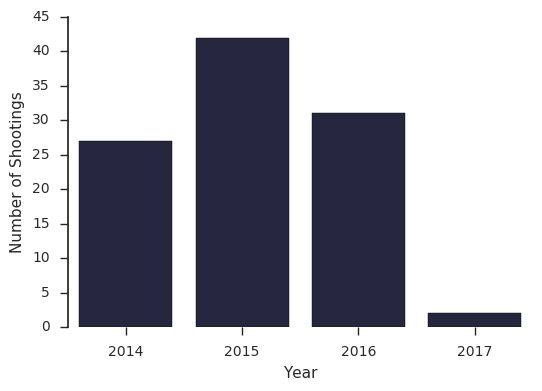

In [21]:
sns.set_style("white")
sns.set_style("ticks")
ax = sns.barplot(x=gb_year.index.year, y="INCNUM", data=gb_year, color="#222343")
sns.despine(top=True, right=True, bottom=True)
ax.set(xlabel="Year", ylabel='Number of Shootings')

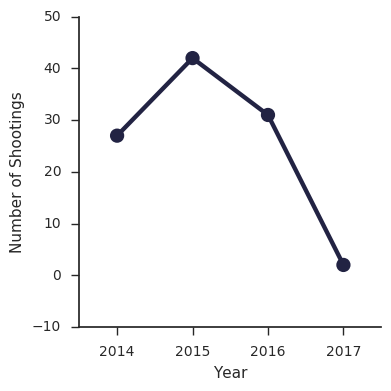

In [22]:
ax = sns.factorplot(x=gb_year.index.year, y="INCNUM", data=gb_year, color="#222343")
ax.set(xlabel="Year", ylabel='Number of Shootings')

Excellent! We now know the answer to our second question. From looking at the bar chart and line chart above, we can see that there were more officer involved shootings in 2015 than 2014 and 2016. However, the overall number of events in those years are fairly close. The number of shootings in 2017 is so low because our data for 2017 only goes through March of that year. It does not appear that the number of officer involved shootings in Indianapolis is increasing or decreasing over the approximately three years of data available.